In [139]:
import pandas as  pd 
import matplotlib.pyplot as plt
import numpy as  np

In [140]:
df =pd.read_csv("brasil-real-estate-1.csv")

In [141]:
df.info()
df =df.drop(columns="Unnamed: 0")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12834 entries, 0 to 12833
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               12834 non-null  int64 
 1   property_type            12834 non-null  object
 2   place_with_parent_names  12834 non-null  object
 3   region                   12834 non-null  object
 4   lat-lon                  11551 non-null  object
 5   area_m2                  12834 non-null  int64 
 6   price_usd                12834 non-null  object
dtypes: int64(2), object(5)
memory usage: 702.0+ KB


# Xem cấu trúc cơ bản

In [142]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12834 entries, 0 to 12833
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   property_type            12834 non-null  object
 1   place_with_parent_names  12834 non-null  object
 2   region                   12834 non-null  object
 3   lat-lon                  11551 non-null  object
 4   area_m2                  12834 non-null  int64 
 5   price_usd                12834 non-null  object
dtypes: int64(1), object(5)
memory usage: 601.7+ KB


,property_type,place_with_parent_names,region,lat-lon,area_m2,price_usd
0,apartment,|Brasil|Alagoas|Maceió|,Northeast,"-9.6443051,-35.7088142",110,"$187,230.85"
1,apartment,|Brasil|Alagoas|Maceió|,Northeast,"-9.6430934,-35.70484",65,"$81,133.37"
2,house,|Brasil|Alagoas|Maceió|,Northeast,"-9.6227033,-35.7297953",211,"$154,465.45"
3,apartment,|Brasil|Alagoas|Maceió|,Northeast,"-9.622837,-35.719556",99,"$146,013.20"
4,apartment,|Brasil|Alagoas|Maceió|,Northeast,"-9.654955,-35.700227",55,"$101,416.71"


# Xử lý dữ liệu

In [143]:
# =========================
# 1. SPLIT place_with_parent_names
# =========================


def split_place_hierarchy(df, col="place_with_parent_names"):
    """
    Split place_with_parent_names into exactly:
    ['country', 'state', 'city']

    - Không sinh thêm cột level_*
    - Chuỗi dài hơn 3 level → cắt
    - Chuỗi ngắn hơn → fill None
    """

    def extract_levels(x):
        parts = [p for p in str(x).split("|") if p]
        parts = parts[:3]                      # chỉ lấy 3 level đầu
        return parts + [None] * (3 - len(parts))

    place_df = (
        df[col]
        .apply(extract_levels)
        .apply(pd.Series)
    )

    place_df.columns = ["country", "state", "city"]

    return df.drop(columns=[col]).join(place_df)



# =========================
# 2. SPLIT lat-lon
# =========================

def split_lat_lon(df, col="lat-lon"):
    """
    Split lat-lon column into numeric lat and lon.
    """

    lat_lon = (
        df[col]
        .str.split(",", expand=True)
        .rename(columns={0: "lat", 1: "lon"})
    )
    lat_lon["lat"] = pd.to_numeric(lat_lon["lat"], errors="coerce")
    lat_lon["lon"] = pd.to_numeric(lat_lon["lon"], errors="coerce")

    return df.drop(columns=[col]).join(lat_lon)


# =========================
# 3. CLEAN price_usd
# =========================

def clean_price_usd(df, col="price_usd"):
    """
    Remove $ and commas, convert to float.
    """

    df[col] = (
        df[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )

    df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


# =========================
# 4. PIPELINE APPLY
# =========================

def preprocess_real_estate(df):
    df = split_place_hierarchy(df)
    df = split_lat_lon(df)
    df = clean_price_usd(df)
    return df


# =========================
# 5. RUN
# =========================

df_clean = preprocess_real_estate(df)
USD_TO_BRL = 5.0
df_clean["price_brl"] = df_clean["price_usd"] * USD_TO_BRL
df_clean.drop(columns="price_usd", inplace= True)
df_clean.head()


,property_type,region,area_m2,country,state,city,lat,lon,price_brl
0,apartment,Northeast,110,Brasil,Alagoas,Maceió,-9.644305,-35.708814,936154.25
1,apartment,Northeast,65,Brasil,Alagoas,Maceió,-9.643093,-35.704840,405666.85
2,house,Northeast,211,Brasil,Alagoas,Maceió,-9.622703,-35.729795,772327.25
3,apartment,Northeast,99,Brasil,Alagoas,Maceió,-9.622837,-35.719556,730066.00
4,apartment,Northeast,55,Brasil,Alagoas,Maceió,-9.654955,-35.700227,507083.55


In [144]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12834 entries, 0 to 12833
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  12834 non-null  object 
 1   region         12834 non-null  object 
 2   area_m2        12834 non-null  int64  
 3   country        12834 non-null  object 
 4   state          12834 non-null  object 
 5   city           12704 non-null  object 
 6   lat            11551 non-null  float64
 7   lon            11551 non-null  float64
 8   price_brl      12834 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 902.5+ KB


In [145]:
df_2 = pd.read_csv("brasil-real-estate-2.csv")
df_2.drop(columns="Unnamed: 0",inplace=True)

In [146]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833 entries, 0 to 12832
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  12833 non-null  object 
 1   state          12833 non-null  object 
 2   region         12833 non-null  object 
 3   lat            12833 non-null  float64
 4   lon            12833 non-null  float64
 5   area_m2        11293 non-null  float64
 6   price_brl      12833 non-null  float64
dtypes: float64(4), object(3)
memory usage: 701.9+ KB


In [147]:
df_2["country"] = "Brasil"
df_2["city"] = None

# Merge 2 file 

In [148]:
df_all = pd.concat(
    [df_clean, df_2],
    axis=0,
    ignore_index=True
)

In [149]:
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25667 entries, 0 to 25666
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  25667 non-null  object 
 1   region         25667 non-null  object 
 2   area_m2        24127 non-null  float64
 3   country        25667 non-null  object 
 4   state          25667 non-null  object 
 5   city           12704 non-null  object 
 6   lat            24384 non-null  float64
 7   lon            24384 non-null  float64
 8   price_brl      25667 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.8+ MB


,property_type,region,area_m2,country,state,city,lat,lon,price_brl
0,apartment,Northeast,110.0,Brasil,Alagoas,Maceió,-9.644305,-35.708814,936154.25
1,apartment,Northeast,65.0,Brasil,Alagoas,Maceió,-9.643093,-35.704840,405666.85
2,house,Northeast,211.0,Brasil,Alagoas,Maceió,-9.622703,-35.729795,772327.25
3,apartment,Northeast,99.0,Brasil,Alagoas,Maceió,-9.622837,-35.719556,730066.00
4,apartment,Northeast,55.0,Brasil,Alagoas,Maceió,-9.654955,-35.700227,507083.55


In [150]:
# lưu file tổng
df_all.to_csv("brasil_final.csv")

In [151]:
null_pct = (
    df_all
    .isna()
    .mean()
    .mul(100)
    .round(2)
    .sort_values(ascending=False)
)

print(null_pct)


city             50.5
area_m2           6.0
lat               5.0
lon               5.0
property_type     0.0
region            0.0
country           0.0
state             0.0
price_brl         0.0
dtype: float64


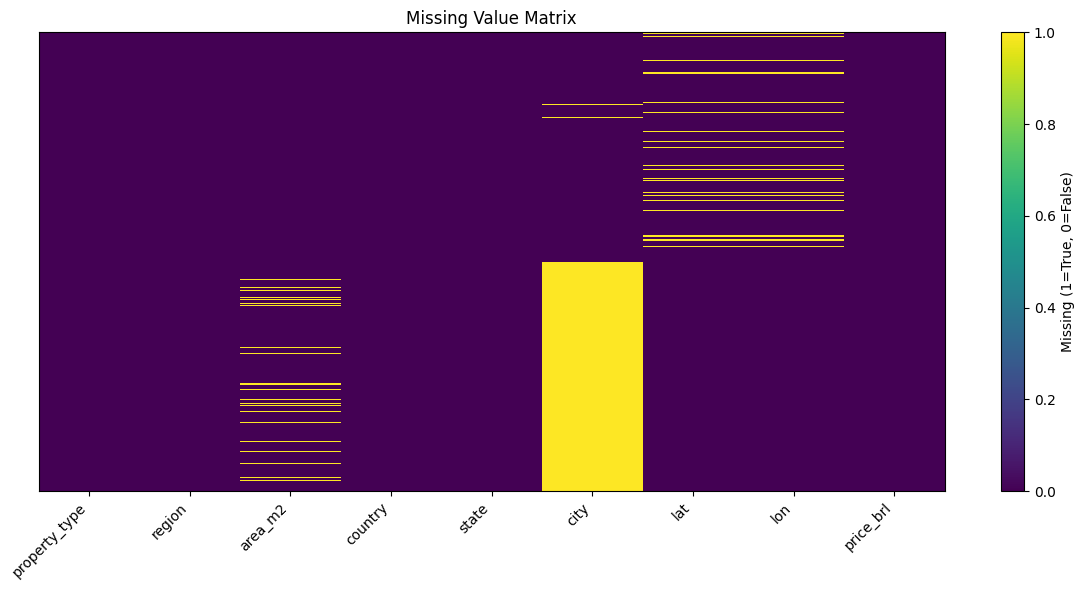

In [152]:

plt.figure(figsize=(12, 6))
plt.imshow(df_all.isna(), aspect="auto", interpolation="nearest")
plt.colorbar(label="Missing (1=True, 0=False)")
plt.yticks([])
plt.xticks(
    ticks=range(len(df_all.columns)),
    labels=df_all.columns,
    rotation=45,
    ha="right"
)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()



city là cột có tỷ lệ thiếu cao nhất và thể hiện thành một khối liên tục. Điều này cho thấy toàn bộ một nguồn dữ liệu không cung cấp thông tin cấp thành phố, dẫn đến missing có tính hệ thống (systematic missing), không phải ngẫu nhiên.

lat và lon có các giá trị thiếu rải rác theo từng dải hàng, phản ánh sự khác biệt về mức độ đầy đủ thông tin không gian giữa hai tập dữ liệu ban đầu.

area_m2 xuất hiện các điểm thiếu phân bố không đều, cho thấy dữ liệu diện tích chưa được chuẩn hoá đầy đủ giữa các nguồn, có thể ảnh hưởng đến các phân tích liên quan đến giá trên mỗi mét vuông.

Các cột property_type, region, country, state và price_brl hầu như không xuất hiện giá trị thiếu, cho thấy đây là các thuộc tính cốt lõi và nhất quán giữa các nguồn dữ liệu.

# Missing ở đây mang ý nghĩa, không phải lỗi → model & EDA cần biết. Cần xử lý theo mục địch 

- ✔ Không impute city / lat / lon → tránh bịa thông tin địa lý
- ✔ Impute area_m2 có điều kiện, không global mean
- ✔ Có area_imputed_flag → model & phân tích không bị “lừa”
- ✔ geo_resolution + data_source giúp kiểm soát bias
- ✔ Tách dataset theo mục tiêu → không trộn bài toán

In [156]:
df = df_all.copy()

# ---- Flags về mức độ thông tin địa lý ----
df["has_city"] = df["city"].notna().astype(int)
df["has_geo"] = (df["lat"].notna() & df["lon"].notna()).astype(int)
df["area_missing_flag"] = df["area_m2"].isna().astype(int)

# ---- Độ phân giải địa lý (semantic feature) ----
# 2 = có city
# 1 = có lat/lon nhưng không có city
# 0 = chỉ có state/region
df["geo_resolution"] = np.select(
    [
        df["has_city"] == 1,
        (df["has_city"] == 0) & (df["has_geo"] == 1),
    ],
    [2, 1],
    default=0
)


In [159]:
df["price_per_m2_raw"] = np.where(
    df["area_m2"].notna(),
    df["price_brl"] / df["area_m2"],
    np.nan
)
group_cols = ["state", "property_type", "geo_resolution"]
area_median_table = (
    df
    .groupby(group_cols, dropna=False)["area_m2"]
    .median()
    .reset_index()
    .rename(columns={"area_m2": "area_m2_group_median"})
)
df = df.merge(
    area_median_table,
    on=group_cols,
    how="left"
)
df["area_m2_imputed"] = np.where(
    df["area_m2"].isna(),
    df["area_m2_group_median"],
    df["area_m2"]
)
df["area_imputed_flag"] = (
    df["area_m2"].isna() & df["area_m2_group_median"].notna()
).astype(int)
df["price_per_m2"] = np.where(
    df["area_m2_imputed"].notna(),
    df["price_brl"] / df["area_m2_imputed"],
    np.nan
)
# Kiểm tra tỷ lệ impute
impute_rate = df["area_imputed_flag"].mean()
print(f"Imputed area_m2 rate: {impute_rate:.2%}")

# Kiểm tra còn area_m2 missing không
remaining_missing = df["area_m2_imputed"].isna().sum()
print("Remaining missing area_m2:", remaining_missing)
# Phân tích theo city
df_city = df[df["has_city"] == 1]

# Phân tích spatial / map / cluster
df_geo = df[df["has_geo"] == 1]

# Phân tích giá / model
df_model = df.copy()  # có flag để model học


Imputed area_m2 rate: 6.00%
Remaining missing area_m2: 1


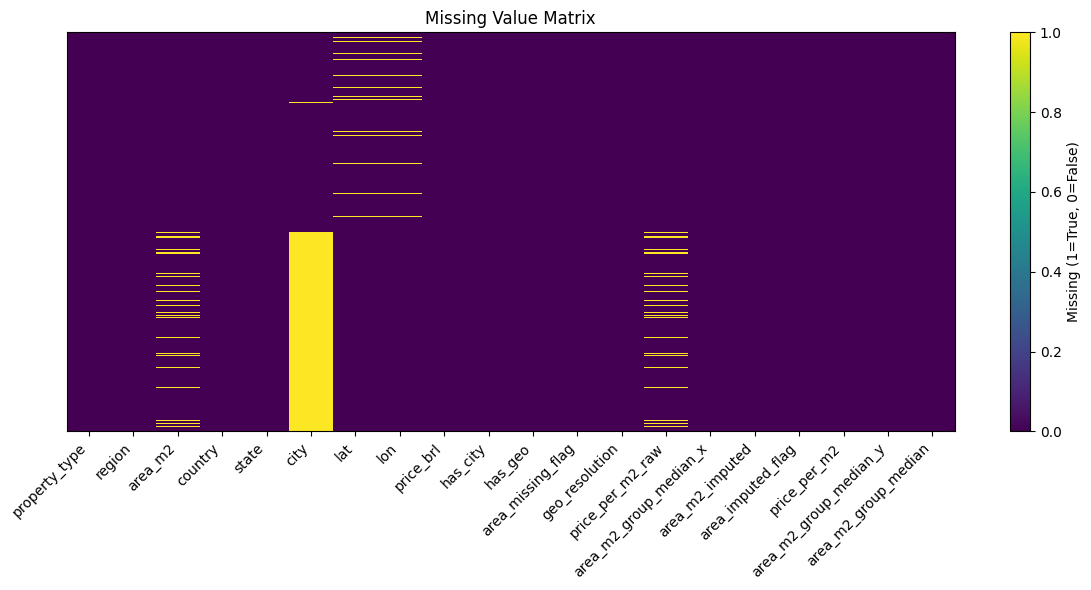

In [162]:

plt.figure(figsize=(12, 6))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest")
plt.colorbar(label="Missing (1=True, 0=False)")
plt.yticks([])
plt.xticks(
    ticks=range(len(df.columns)),
    labels=df.columns,
    rotation=45,
    ha="right"
)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

In [163]:
df.to_csv("brasil_final_2.csv")